# SDP

### Author: Yogeshkarna Govindaraj

Reference:
    https://pcl.readthedocs.io/projects/tutorials/en/latest/walkthrough.html#walkthrough

#### Part-1 :Adding seeding locations 

In [1]:
import numpy as np 
import open3d as o3d
import pclpy
from pclpy import pcl

In [2]:
# Read .ply file
# input_file = "segmented_cloud.ply"
input_file = "bun_zipper.ply"
# Read the point cloud 
pcd = o3d.io.read_point_cloud(input_file) 

In [3]:
# Visualize the point cloud within open3d
o3d.visualization.draw_geometries([pcd]) 

# Convert open3d format to numpy array
# Here, you have the point cloud in numpy format. 
dataset = np.asarray(pcd.points)

In [4]:
# plyreader = pcl.io.PLYReader()
# data = plyreader.read("segmented_cloud.ply", pcl.PointCloud.PointXYZ())

### Statistical Outlier Removal
- (+) Results are satisfying 
- (-) The telephone wire points are removed.

In [5]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])
    
print("Statistical oulier removal")
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=10,std_ratio=20)
filtered_pcd = pcd.select_by_index(ind)
display_inlier_outlier(pcd, ind)

Statistical oulier removal
Showing outliers (red) and inliers (gray): 


In [6]:
pcd_pp = pcd.select_by_index(ind)
# o3d.io.write_point_cloud("dataset_3d.xyz", pcd_pp)

dataset_3d = np.asarray(pcd_pp.points)
dataset_3d

array([[-0.0378297 ,  0.12794   ,  0.00447467],
       [-0.0447794 ,  0.128887  ,  0.00190497],
       [-0.0680095 ,  0.151244  ,  0.0371953 ],
       ...,
       [-0.0704544 ,  0.150585  , -0.0434585 ],
       [-0.0310262 ,  0.153728  , -0.00354608],
       [-0.0400442 ,  0.15362   , -0.00816685]])

### K-means initial testing with 2D dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans,DBSCAN

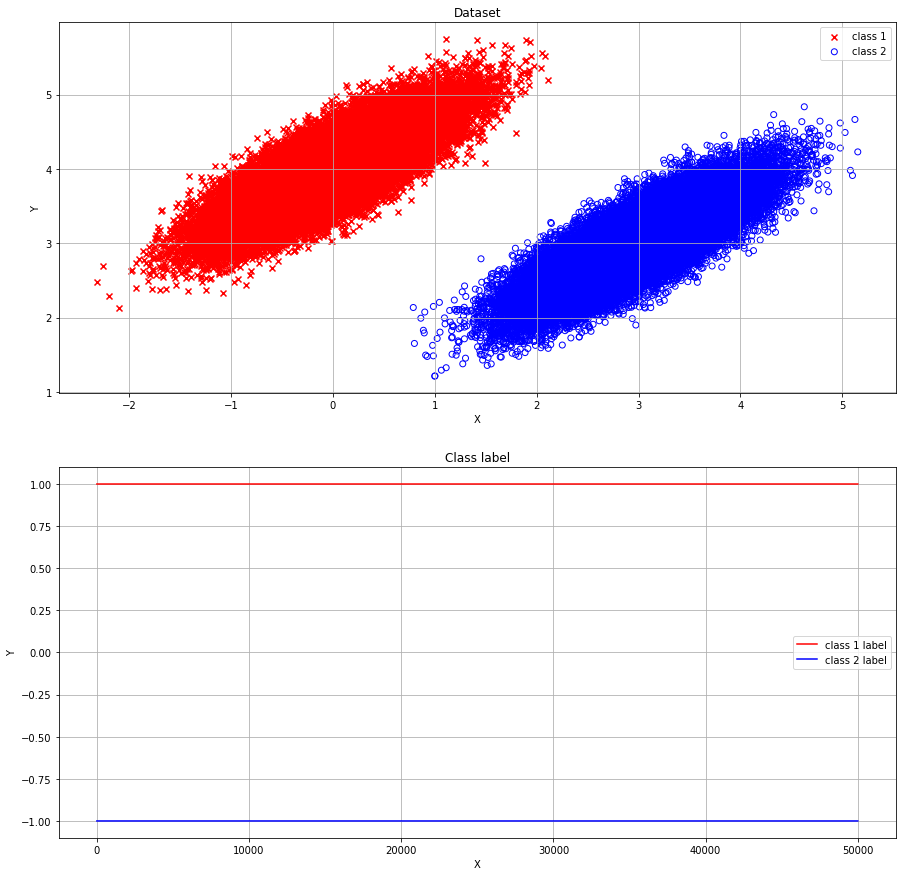

In [8]:
#parameters
mean1= [0,4]
mean2= [3,3]
cov = np.array([[0.3,0.2],[0.2,0.2]])
total_points = 50000
#dataset
dataset1 = np.random.multivariate_normal(mean1,cov,total_points)
dataset2 = np.random.multivariate_normal(mean2,cov,total_points)
d1label = np.ones(total_points)
d2label = np.full(total_points,-1)
#plot
fig, ax = plt.subplots(2,1,figsize=(15,15))
ax[0].scatter(dataset1[:,0],dataset1[:,1],label='class 1',c= 'r',marker='x')
ax[0].scatter(dataset2[:,0],dataset2[:,1],label='class 2',facecolors='none', edgecolors='b')
ax[0].set_title('Dataset')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(d1label,label='class 1 label',c= 'r')
ax[1].plot(d2label,label='class 2 label',c= 'b')
ax[1].set_title('Class label')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].legend()
ax[1].grid(True)

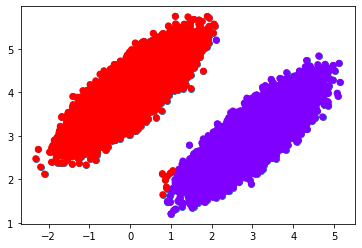

In [9]:
#stacking the dataset 
X = np.vstack((dataset1,dataset2))

plt.scatter(X[:,0],X[:,1], label='True Position')

#k-means clustering 
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')

### K-Means 3D point cloud 

In [10]:
# db = DBSCAN(eps=20, min_samples=5).fit(dataset_3d)
# labels_3d = db.labels_


In [22]:
kmeans_3d = KMeans(n_clusters= 1000,n_init=2, verbose=0)
kmeans_3d.fit(dataset_3d)
labels_3d= kmeans_3d.labels_

In [23]:
centroids = kmeans_3d.cluster_centers_

labels_3d = labels_3d/ max(labels_3d)
print(labels_3d)

[0.13913914 0.48448448 0.63863864 ... 0.77277277 0.64564565 0.48748749]


In [24]:
viridis = plt.cm.get_cmap('viridis', 8)
colors= viridis(labels_3d)
print(colors)

[[0.275191 0.194905 0.496005 1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 ...
 [0.626579 0.854645 0.223353 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.153364 0.497    0.557724 1.      ]]


In [25]:

a = colors[:,:3]
print(a)

# permutation = [3, 1, 2, 0]
# idx = np.empty_like(permutation)
# idx[permutation] = np.arange(len(permutation))
# print(a[:, idx])  # return a rearranged copy

# a[:] = a[:, idx]  # in-place modification of a

[[0.275191 0.194905 0.496005]
 [0.153364 0.497    0.557724]
 [0.288921 0.758394 0.428426]
 ...
 [0.626579 0.854645 0.223353]
 [0.288921 0.758394 0.428426]
 [0.153364 0.497    0.557724]]


In [26]:
output = np.hstack((dataset_3d,a))
compressed= centroids
np.savetxt("output_compresed.txt", compressed)
np.savetxt("output.txt", output)
pcd_c = o3d.io.read_point_cloud("output_compresed.txt", format='xyz')
pcd = o3d.io.read_point_cloud("output.txt", format='xyzrgb')


In [27]:

o3d.visualization.draw_geometries([pcd]) 
o3d.visualization.draw_geometries([pcd_c]) 